In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from datetime import datetime
from geopy import distance
from sklearn.preprocessing import OneHotEncoder


In [3]:
path = '/Users/philipp/Documents/02_Master_Uni/Uni_Tübingen/Semester_1/06 Data Literacy/02 Project/datasets_penguins'

files = os.listdir(path)

df = pd.concat([pd.read_csv(path + '/' + file) for file in files])

df = df.drop(columns=['equinox', 'original_track_id'])

In [4]:
# Test if there is more than one track_id bird_id pair per bird_id
print(df.groupby(['bird_id', 'track_id']).size().reset_index().groupby('bird_id').size().max())

# Need new ID that is unique for each bird and track
df['unique_id'] = df['bird_id'].astype(str) + df['track_id'].astype(str)


4


In [5]:
# Sort dataframe in date/time per bird and trip
df = df.sort_values(['date_gmt', 'unique_id', 'time_gmt']).reset_index(drop=True)

In [6]:
df['pos_bird'] = list(zip(df['latitude'], df['longitude']))
df['pos_colony'] = list(zip(df['lat_colony'], df['lon_colony']))

In [7]:
# breed_status is redundant

print(df['breed_stage'].nunique(), df['breed_status'].nunique())
print(df['breed_stage'].unique(), df['breed_status'].unique())
df = df.drop(columns='breed_status')

7 2
['brood-guard' 'creche' 'incubation' 'chick-rearing' 'winter'
 'non-breeding' 'breeding'] ['breeding' 'non-breeding']


## Features

In [8]:
# Calculate geodesic distance between bird and colony
# Elliposid used: WGS-84  

df['km_to_colony'] = df.apply(lambda row: distance.distance(row['pos_bird'], row['pos_colony']).km, axis=1)

In [9]:
# Below calculation is similar to performing weighted average

# Calculate mean distance and std per penguin
mean_distance_per_penguin = df.groupby('unique_id')['km_to_colony'].mean()
std_distance_per_penguin = df.groupby('unique_id')['km_to_colony'].std()

# Average over mean distances
mean_distance_overall = mean_distance_per_penguin.mean()
std_distance_overall = mean_distance_per_penguin.std()
print(mean_distance_overall, std_distance_overall)

82.44624509492944 238.55919947463335


In [10]:
# Position relative to colony
directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N']

for i in range(len(df)):
    delta_lat = df.at[i,'latitude'] - df.at[i, 'lat_colony']
    delta_lon = df.at[i, 'longitude'] - df.at[i, 'lon_colony']
    degrees_temp = math.atan2(delta_lat, delta_lon)/math.pi*180
    if degrees_temp < 0:
        degrees_final = degrees_temp + 360
    else:
        degrees_final = degrees_temp

    lookup = round(degrees_final/45) # because of 8 possible directions

    df.at[i, 'relative_position'] = directions[lookup]
    


In [11]:
# Direction of travel
# If bird_id changes: relative position to colony
# If bird_id stays the same: calculate direction of travel

df.at[0, 'direction_of_travel'] = df.at[0, 'relative_position']

for i in range(1, len(df)):
    if df.at[i, 'unique_id'] != df.at[i-1,'unique_id']:
        df.at[i, 'direction_of_travel'] = df.at[i, 'relative_position']
    else:
        delta_lat = delta_lat = df.iloc[i]['latitude'] - df.iloc[i-1]['latitude']
        delta_lon = df.iloc[i]['longitude'] - df.iloc[i-1]['longitude']
        degrees_temp = math.atan2(delta_lat, delta_lon)/math.pi*180

        if degrees_temp < 0:
            degrees_final = degrees_temp + 360
        else:
            degrees_final = degrees_temp

        lookup = round(degrees_final/45)

        df.at[i, 'direction_of_travel'] = directions[lookup]


In [12]:
# Distance travelled between each measure (might define previous steps as formulas and apply them directly)

df['km_since_last_measure'] = 0
df['km_since_last_measure'] = df['km_since_last_measure'].astype(float)
for i in range(1, len(df)):
    if df.at[i, 'unique_id'] == df.at[i-1, 'unique_id']:
        df.at[i, 'km_since_last_measure'] = distance.distance(df.at[i,'pos_bird'], df.at[i-1,'pos_bird']).km
    else:
        df.at[i, 'km_since_last_measure'] = 0

In [13]:
# Distace North and East

# EVTL NOCH SOUTH AND WEST REIN (weil aktuell noch negative werte)

df['delta_km_north'] = 0
df['delta_km_north'] = df['delta_km_north'].astype(float)

for i in range(1, len(df)):
    start = (0, df.at[i-1, 'longitude'])
    finish = (0, df.at[i, 'longitude'])
    if df.at[i, 'unique_id'] == df.at[i-1, 'unique_id']:
        df.at[i, 'delta_km_north'] = distance.distance(start, finish).km
    else:
        df.at[i, 'delta_km_north'] = 0


df['delta_km_east'] = 0
df['delta_km_east'] = df['delta_km_east'].astype(float)

for i in range(1, len(df)):
    start = (df.at[i-1, 'latitude'], 0)
    finish = (df.at[i, 'latitude'], 0)
    if df.at[i, 'unique_id'] == df.at[i-1, 'unique_id']:
        df.at[i, 'delta_km_east'] = distance.distance(start, finish).km
    else:
        df.at[i, 'delta_km_east'] = 0

In [14]:
# Replace dd-mm-yyyy or yyyy-mm-dd with dd/mm/yyyy
date_target_format = '%d/%m/%Y'

for i in range(len(df)):
    # check if format is YYYY-MM-DD
    if '-' in df.at[i, 'date_gmt'] and datetime.strptime(df.at[i, 'date_gmt'], '%Y-%m-%d'): 
        df.at[i, 'date_gmt'] = datetime.strptime(df.at[i, 'date_gmt'], '%Y-%m-%d').strftime(date_target_format)
    # check if format is DD-MM-YYYY
    elif '-' in df.at[i, 'date_gmt'] and datetime.strptime(df.at[i, 'date_gmt'], '%d-%m-%Y'):
        df.at[i, 'date_gmt'] = datetime.strptime(df.at[i, 'date_gmt'], '%d-%m-%Y').strftime(date_target_format)

In [15]:
# Time difference betweeen measures in minutes(time_gmt = hh:mm:ss, date_gmt = dd/mm/yyyy)
# Create datetime column

datetime_format = '%d/%m/%Y %H:%M:%S'

df['datetime'] = df['date_gmt'].astype(str) + ' ' + df['time_gmt'].astype(str)

df['minutes_since_last_measure'] = 0
df['minutes_since_last_measure'] = df['minutes_since_last_measure'].astype(float)
for i in range(1, len(df)):
    if df.at[i, 'unique_id'] == df.at[i-1, 'unique_id']:
        timestamp_1 = datetime.strptime(df.at[i-1, 'datetime'], datetime_format)
        timestamp_2 = datetime.strptime(df.at[i, 'datetime'], datetime_format)
        df.at[i,'minutes_since_last_measure'] = (timestamp_2 - timestamp_1).total_seconds()/60
    else:
        df.at[i, 'minutes_since_last_measure'] = 0

In [16]:
print(df['minutes_since_last_measure'].describe())

count    415643.000000
mean         28.524257
std          90.789919
min           0.000000
25%           3.000000
50%           9.000000
75%          32.000000
max       20033.000000
Name: minutes_since_last_measure, dtype: float64


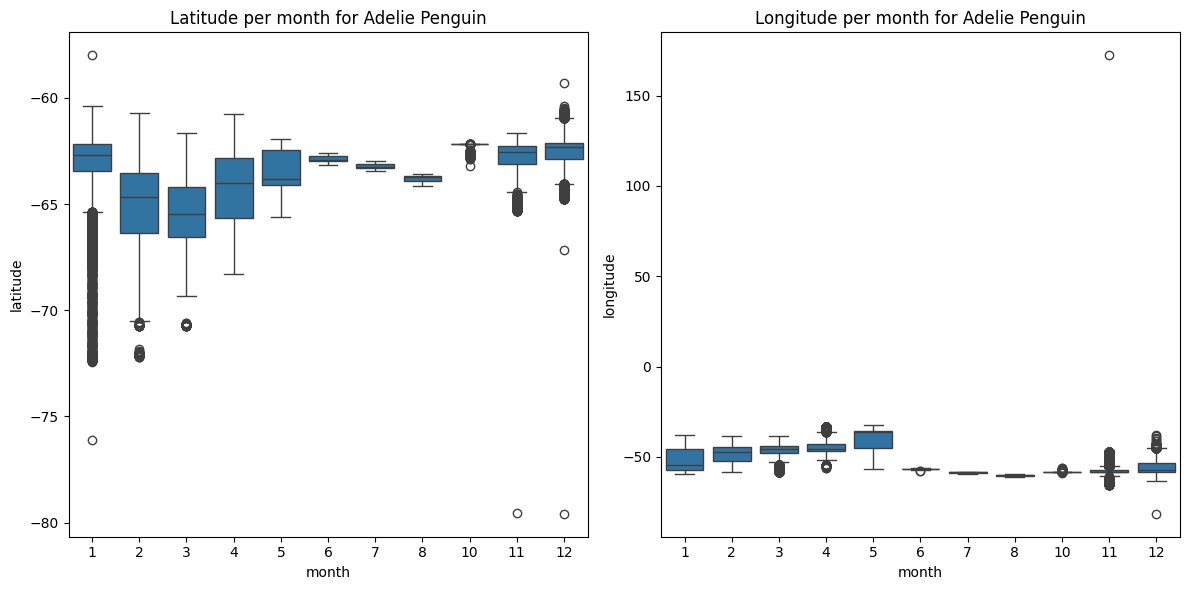

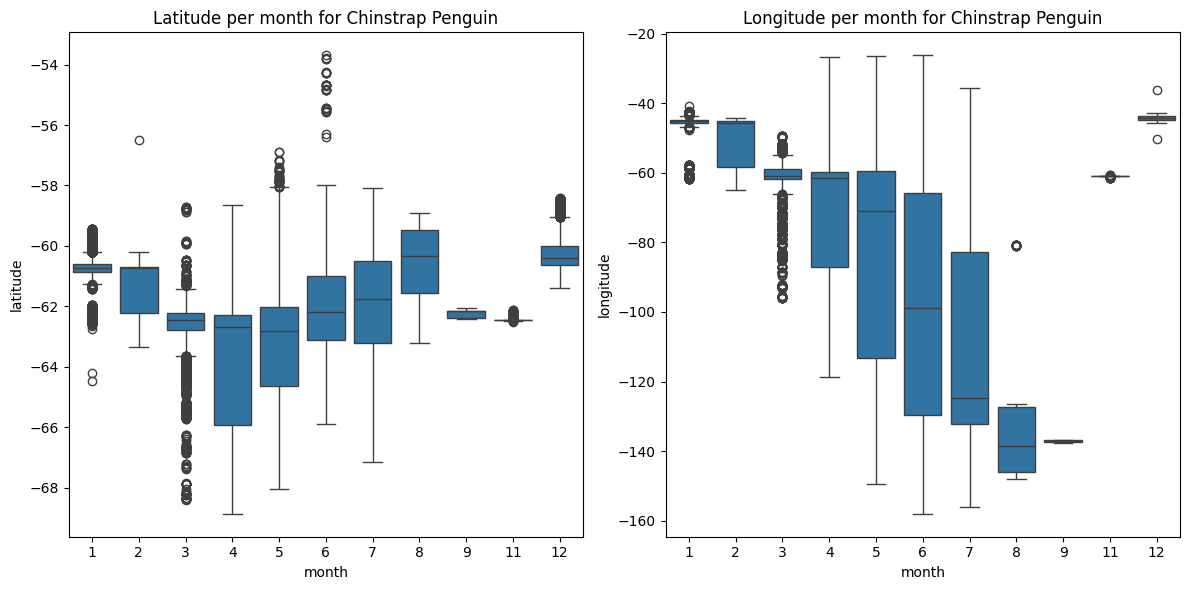

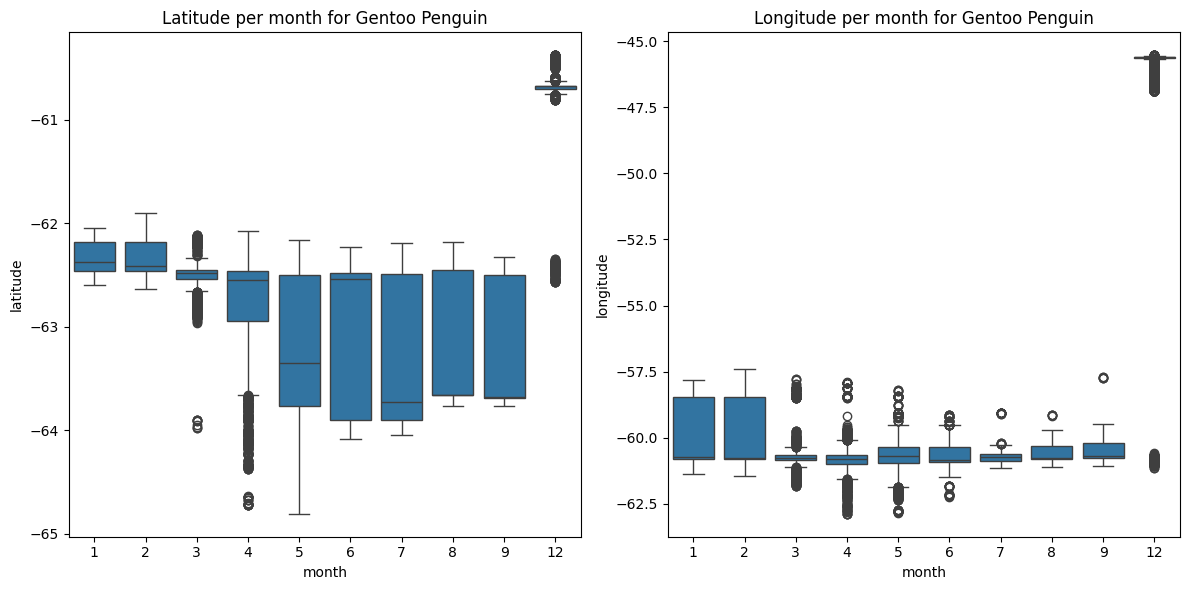

In [17]:
# Plot coordinates of different species per month (no matter the year)

df['month'] = df['date_gmt'].str.split('/').str[1]
df['month'] = df['month'].astype(int)
# create one plot per species, with moth on x-axis and latitude on y-axis and one per species with month on x-axis and longitude on y-axis
species = df['common_name'].unique()

months = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']



for specie in species:
    df_specie = df[df['common_name'] == specie]
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    sns.boxplot(x='month', y='latitude', data=df_specie, ax=ax[0])
    ax[0].set_title('Latitude per month for ' + specie)
    sns.boxplot(x='month', y='longitude', data=df_specie, ax=ax[1])
    ax[1].set_title('Longitude per month for ' + specie)
    plt.tight_layout()
    plt.show()


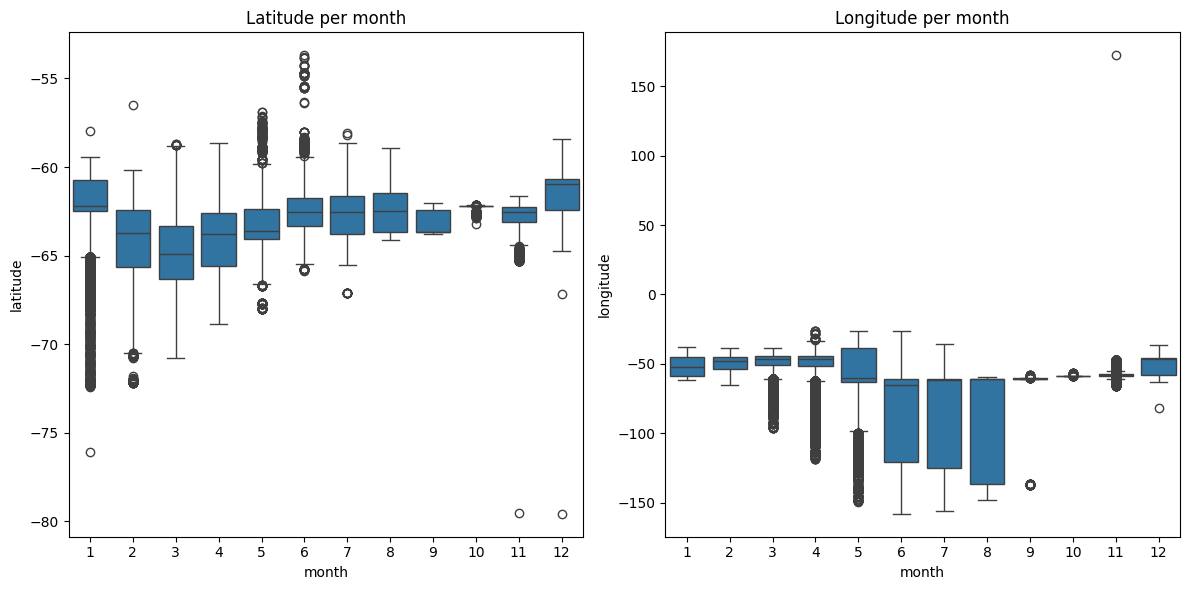

In [18]:

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(x='month', y='latitude', data=df, ax=ax[0])
ax[0].set_title('Latitude per month')
sns.boxplot(x='month', y='longitude', data=df, ax=ax[1])
ax[1].set_title('Longitude per month')
plt.tight_layout()
plt.show()

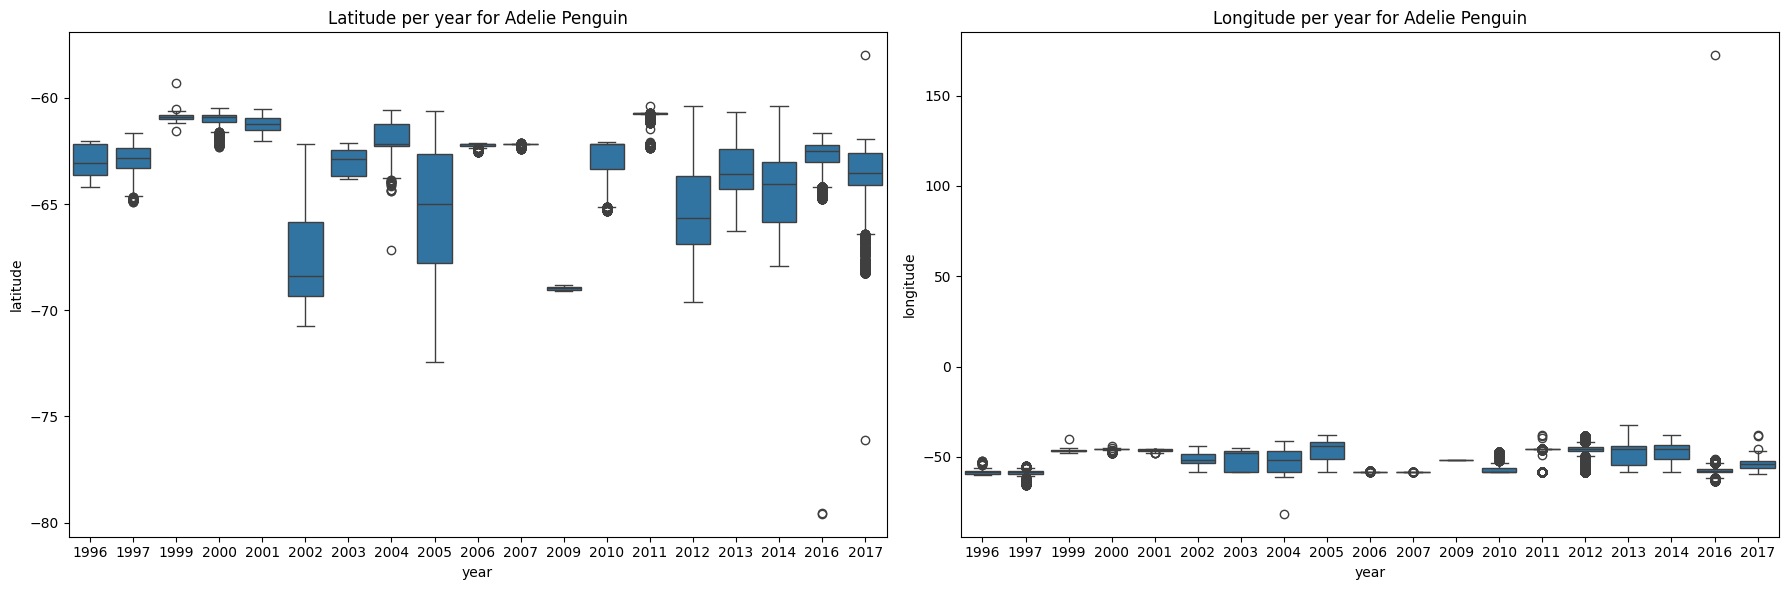

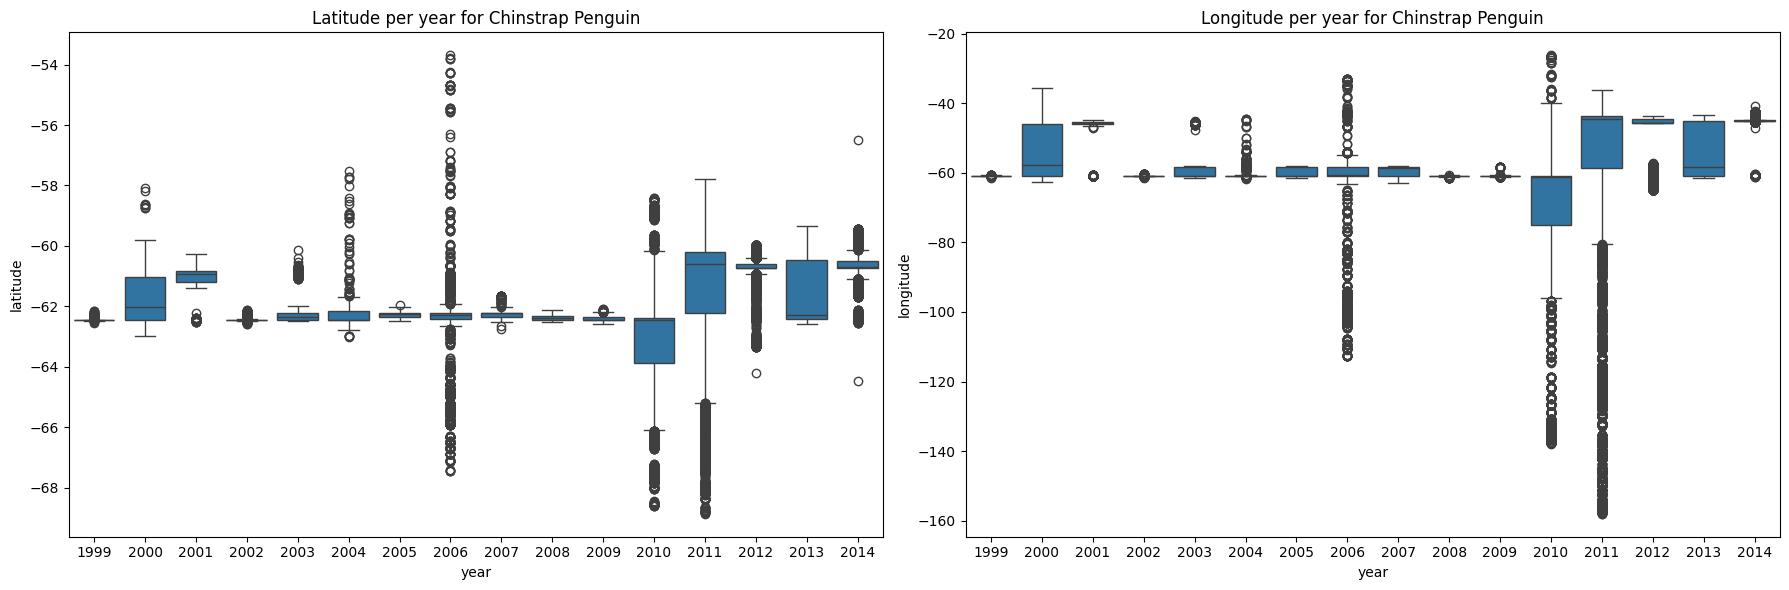

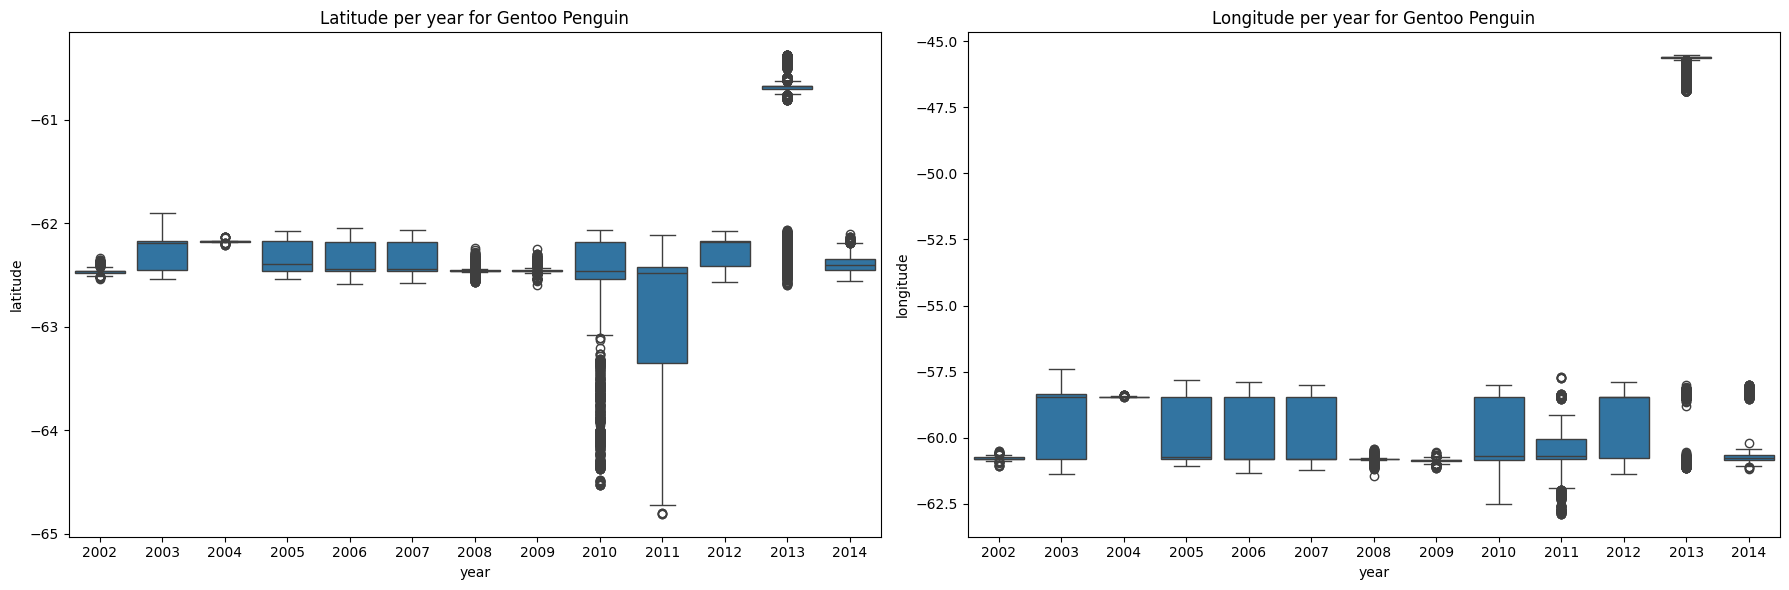

In [19]:
df['year'] = df['date_gmt'].str.split('/').str[2]
df['year'] = df['year'].astype(int)

for specie in species:
    df_specie = df[df['common_name'] == specie]
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    sns.boxplot(x='year', y='latitude', data=df_specie, ax=ax[0])
    ax[0].set_title('Latitude per year for ' + specie)
    sns.boxplot(x='year', y='longitude', data=df_specie, ax=ax[1])
    ax[1].set_title('Longitude per year for ' + specie)
    plt.tight_layout()
    plt.show()

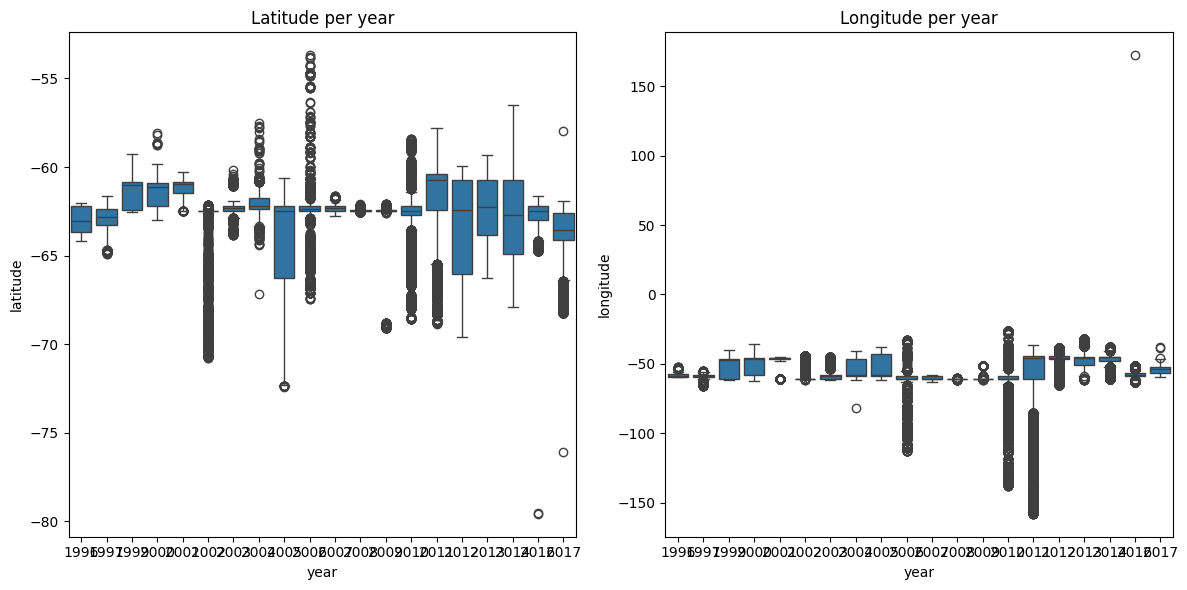

In [20]:
# plots in general
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
sns.boxplot(x='year', y='latitude', data = df, ax=ax[0])
ax[0].set_title('Latitude per year')
sns.boxplot(x='year', y='longitude', data = df, ax=ax[1])
ax[1].set_title('Longitude per year')
plt.tight_layout()
plt.show()

# x axis label anpassen

## General Questions:

1. How handle outliers?
2. 

In [21]:
print(df.columns)

Index(['dataset_id', 'scientific_name', 'common_name', 'site_name',
       'colony_name', 'lat_colony', 'lon_colony', 'device', 'bird_id',
       'track_id', 'age', 'sex', 'breed_stage', 'date_gmt', 'time_gmt',
       'latitude', 'longitude', 'argos_quality', 'unique_id', 'pos_bird',
       'pos_colony', 'km_to_colony', 'relative_position',
       'direction_of_travel', 'km_since_last_measure', 'delta_km_north',
       'delta_km_east', 'datetime', 'minutes_since_last_measure', 'month',
       'year'],
      dtype='object')


In [22]:
# TargetEncoder vllt lieber benutzen ? (nochmal reinlesen)

# One Hot Encoding:
categorical_cols = ['breed_stage', 'relative_position', 'direction_of_travel']
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(df[categorical_cols])

one_hot_df = pd.DataFrame(one_hot_encoded, columns = encoder.get_feature_names_out(categorical_cols))

df_encoded = pd.concat([df, one_hot_df], axis=1)
df_encoded = df_encoded.drop(categorical_cols, axis=1)

print(df_encoded.columns)

Index(['dataset_id', 'scientific_name', 'common_name', 'site_name',
       'colony_name', 'lat_colony', 'lon_colony', 'device', 'bird_id',
       'track_id', 'age', 'sex', 'date_gmt', 'time_gmt', 'latitude',
       'longitude', 'argos_quality', 'unique_id', 'pos_bird', 'pos_colony',
       'km_to_colony', 'km_since_last_measure', 'delta_km_north',
       'delta_km_east', 'datetime', 'minutes_since_last_measure', 'month',
       'year', 'breed_stage_breeding', 'breed_stage_brood-guard',
       'breed_stage_chick-rearing', 'breed_stage_creche',
       'breed_stage_incubation', 'breed_stage_non-breeding',
       'breed_stage_winter', 'relative_position_E', 'relative_position_N',
       'relative_position_NE', 'relative_position_NW', 'relative_position_S',
       'relative_position_SE', 'relative_position_SW', 'relative_position_W',
       'direction_of_travel_E', 'direction_of_travel_N',
       'direction_of_travel_NE', 'direction_of_travel_NW',
       'direction_of_travel_S', 'direction_

In [23]:
# save df_encoded to csv
path_new = '/Users/philipp/Documents/02_Master_Uni/Uni_Tübingen/Semester_1/06 Data Literacy/02 Project/projectP/data'
df_encoded.to_csv(path_new + '/' + 'penguins_cleaned.csv', index=False)



